In [2]:
import pandas as pd
import numpy as np
import cv2
from os import listdir
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train_metadata = pd.read_csv('../data/raw/train/train_metadata.csv')
train_labels = pd.read_csv('../data/raw/train/train_labels.csv')

test = pd.read_csv('../data/raw/test/test_metadata.csv')

print(train_metadata.shape)
print(train_labels.shape)

print(test.shape)

(573048, 8)
(573048, 2)
(14160, 3)


In [4]:
train_metadata.head()

,filename,url,project_id,num_frames,crowd_score,tier1,micro,nano
0,100000.mp4,s3://drivendata-competition-clog-loss/train/10...,M,54,0.000000,True,False,False
1,100001.mp4,s3://drivendata-competition-clog-loss/train/10...,F,48,0.022769,False,False,False
2,100002.mp4,s3://drivendata-competition-clog-loss/train/10...,H,122,0.000000,True,False,False
3,100003.mp4,s3://drivendata-competition-clog-loss/train/10...,E,55,0.000000,True,False,False
4,100004.mp4,s3://drivendata-competition-clog-loss/train/10...,C,56,0.000000,True,False,False


In [5]:
train_labels.head()

,filename,stalled
0,100000.mp4,0
1,100001.mp4,0
2,100002.mp4,0
3,100003.mp4,0
4,100004.mp4,0


In [6]:
test.head()

,filename,url,num_frames
0,100032.mp4,s3://drivendata-competition-clog-loss/test/100...,37
1,100037.mp4,s3://drivendata-competition-clog-loss/test/100...,49
2,100139.mp4,s3://drivendata-competition-clog-loss/test/100...,53
3,100182.mp4,s3://drivendata-competition-clog-loss/test/100...,51
4,100214.mp4,s3://drivendata-competition-clog-loss/test/100...,48


In [7]:
train = pd.merge(train_labels,train_metadata,on='filename')
train.shape

(573048, 9)

In [8]:
train.stalled.values.sum()

1887

In [9]:
list_videos = os.listdir('../data/raw/train/nano/')

In [10]:
len(list_videos)

1413

In [11]:
train_nano = train[train.filename.isin(list_videos)]

In [12]:
train_nano.shape

(1413, 9)

In [13]:
train_nano.stalled.values.sum()

706

In [14]:
print(train.num_frames.median(),train.num_frames.min(),train.num_frames.max())
print(train_nano.num_frames.median(),train_nano.num_frames.min(),train_nano.num_frames.max())
print(test.num_frames.median(),test.num_frames.min(),test.num_frames.max())

56.0 17 434
58.0 24 185
56.0 20 307


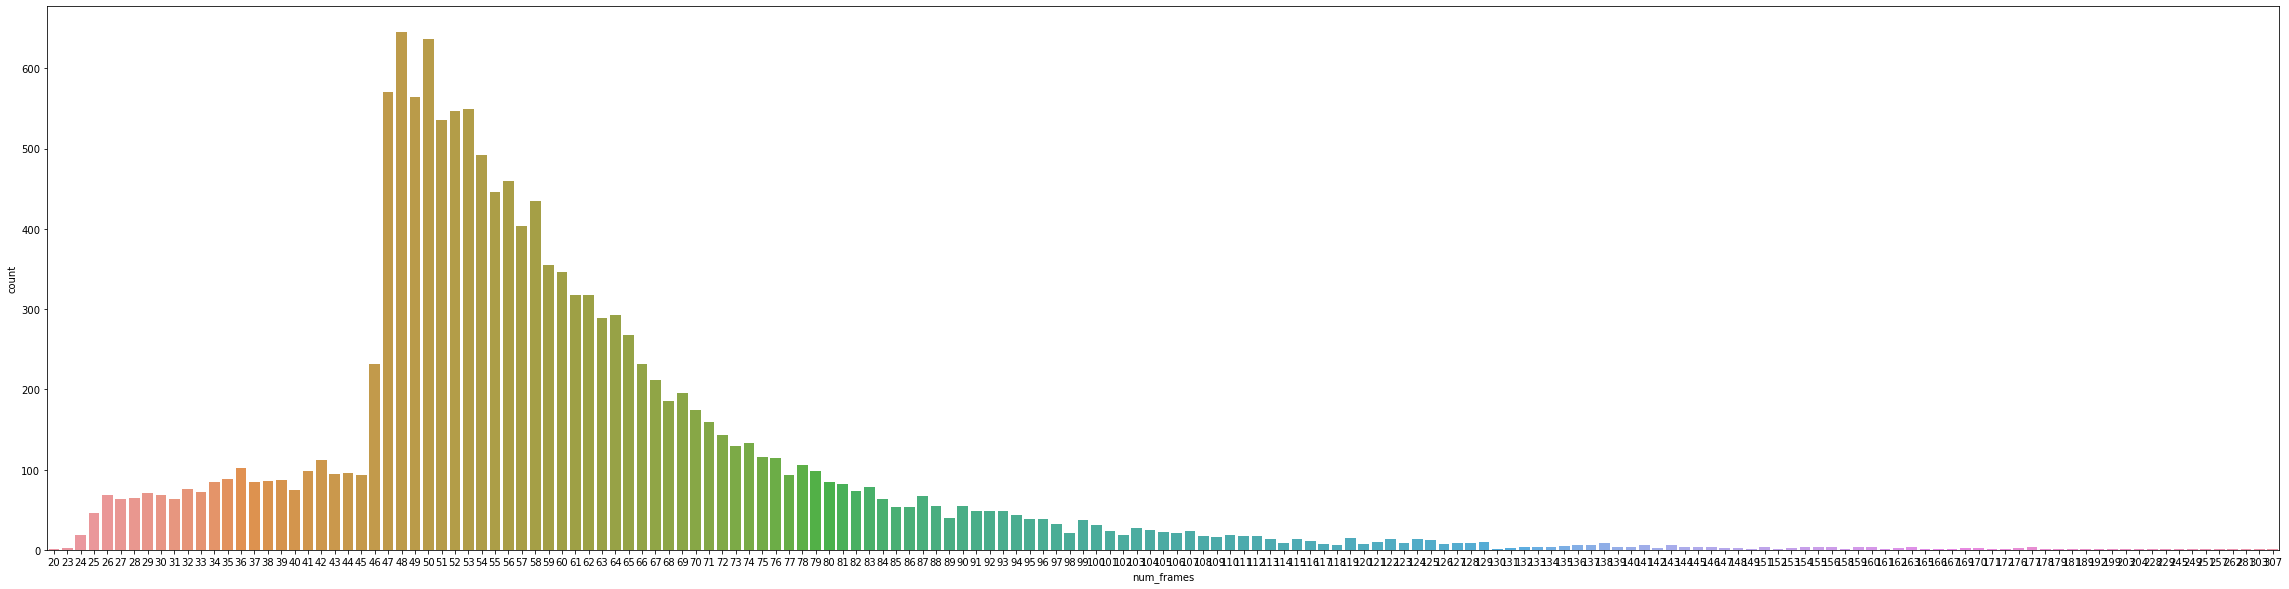

In [15]:
plt.figure(figsize=(40,10))
sns.countplot(x='num_frames', data=test)

In [16]:
th = 100
test[test.num_frames < th].shape[0] / test.shape[0]

0.9584039548022599

In [17]:
lower_orange = np.array([0, 80, 50],np.uint8)
upper_orange = np.array([255, 255, 255],np.uint8)

dim = 100
#thresh = 150

void_frame = np.zeros((dim,dim),np.uint8)

data_dir = '../data/raw/train/nano/'


def normalize_video(video):

    feature = []

    success, image = video.read()
    frames = []
    while success:
        frames.append(image)   
        success,image = video.read()

    # Same num frames
    n = 100 - len(frames)
    if(n < 0):
        idx = int(n/2)
        if (n%2==0):
            frames = frames[idx:-idx]
        else:
            frames = frames[idx:-idx+1]

    for frame in frames:

        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        contour = cv2.inRange(hsv, lower_orange, upper_orange)

        x,y,w,h = cv2.boundingRect(contour)

        croped_img = frame[y:y+h,x:x+w]
        croped_mask = contour[y:y+h,x:x+w]

        resized_gray_img = cv2.resize(croped_img,(dim,dim))[:,:,2]
        resized_mask = cv2.resize(croped_mask,(dim,dim))

        for row in range(dim):
            i = 0
            is_contour = False

            while((i < dim) & (not is_contour)):
                if(resized_mask[row,i]):
                    is_contour = True
                resized_gray_img[row,i] = 0
                i+=1
            
            if not is_contour: continue
            is_contour = False

            i = dim -1

            while((i >= 0) & (not is_contour)):
                if(resized_mask[row,i]):
                    is_contour = True
                resized_gray_img[row,i] = 0
                i-=1
        
        #mask_inv = cv2.bitwise_not(resized_mask)
        #img = cv2.bitwise_and(resized_gray_img,resized_gray_img,mask = mask_inv)

        #bw = cv2.threshold(gray, thresh, 255, cv2.THRESH_BINARY)[1]

        feature.append(resized_gray_img)

    if(n > 0):
        feature = np.concatenate((feature,np.zeros((n,dim,dim),np.uint8)),axis=0)
    
    return np.array(feature)

In [18]:
file_name = 'train2_norm_videos.npz'
data_dir = '../data/raw/train/nano/'

features = []

files = train_nano[0:5].filename.values

with tqdm(total=len(files)) as pbar:
    for f in files:

        path = data_dir + f
        video = cv2.VideoCapture(path)

        tmp = f, normalize_video(video)
            
        features.append(tmp)
        pbar.update(1)

path = '../data/' + file_name
np.savez(path, **{i:f for i, f in features}) 

100%|██████████| 5/5 [00:01<00:00,  4.16it/s]


In [19]:
file_name= 'train2_norm_videos.npz'
features = np.load('../data/'+file_name)

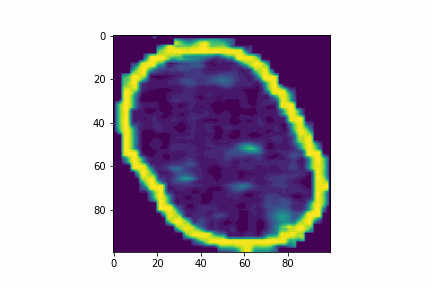

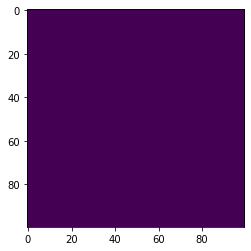

In [22]:
import time
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
from IPython.display import Image

x = features[str(train_nano.iloc[3,0])]

fig = plt.figure()
ims = []
for i in range(len(x)):
    im = plt.imshow(x[i])
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)

ani.save('im.gif', writer=PillowWriter(fps=10))

Image(filename="im.gif")